# Basic LSTM implementation in PyTorch

## Sequence prediction of a Sine Wave

- Training a simple LSTM to predict the next value from the values of a sequence of Sine wave, LSTM works here by remembering the past trends of input and using that trneds to predict the next value in the sequence
-  Example: Given `[0.0, 0.84, 0.91, 0.14]` (sine wave values), predict the next value `-0.76`
- Input: A sequence of past values (e.g., last 50 time steps)
    - Output: The next value(s) in the sequence
    - Think of it like: "Given the last 50 points of a sine wave, predict the next point"
 ### Regular neural networks forget the past. LSTMs have a memory cell that:
  - Forget Gate: Decides what to forget from previous time steps
  - Input Gate: Decides what new info to store
  - Output Gate: Decides what to output based on memory

In [28]:
# step1 - generating the data

import numpy as np
import torch

x=np.linspace(0, 100, 1000)  # divide the interval between 0 and 100 into 1000 equal parts
data=np.sin(x)               # here np.sin() expects radians

# creatiing the sequence, input seq -> target sequence
def create_seq(data, seq_len):
    xs, ys=[], []   # creating multiple inp, target sequences from a single dataset
    for i in range(len(data)-seq_len):
        x=data[i:i+seq_len]   # seq of values
        y=data[i+seq_len]   #next single value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x, y = create_seq(data, 50)
# print(len(x), y)

### LSTM Architecture

In [29]:
import torch.nn as nn

class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1):           # input size is the number of values we pass at each time instant,  # hidden_size is the size of our hidden state, # num_layers is the num of LSTMs stacked up, output_size is the no of values to predict    
                                                                                        
        super().__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers

        #lstm layer
        self.lstm=nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        #fc layer to get the output
        self.fc=nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x is our input, shape: (batch_size, seq_len, input_size)
        lstm_out, _ =self.lstm(x)     # lstm output is h_t( hidden state ) lstm_out shape: (32, 50, hidden_size=64)
                                      # This is h_1, h_2, ..., h_50 for each sample
        lstm_last_out = lstm_out[:, -1, :]     # extract only h_50 ( 32, 64)
        prediction = self.fc(lstm_last_out)    # we make pred, y= w.h_50 + b
        return prediction
                                                                                            

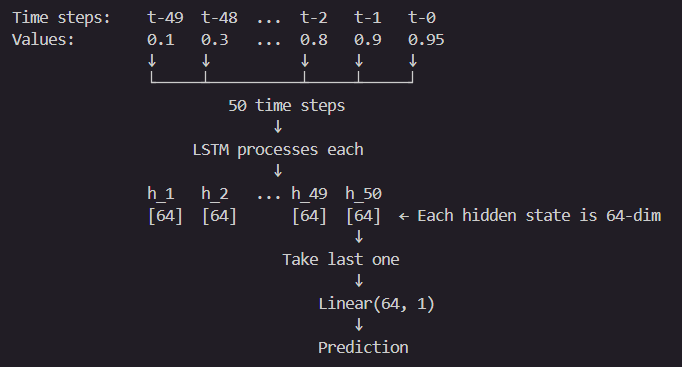

In [41]:
x=torch.FloatTensor(x).unsqueeze(-1)
y=torch.FloatTensor(y).unsqueeze(-1)

In [42]:
model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs =100

for epoch in range(epochs):
    prediction=model(x)
    loss=criterion(prediction, y)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


ValueError: LSTM: Expected input to be 2D or 3D, got 10D instead